In [8]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd

import time

import jax
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC
from numpyro.infer import SVI, Trace_ELBO, Predictive
import numpyro.diagnostics

from termcolor import colored
import matplotlib.pyplot as plt


import dill
import pickle
import arviz as az

In [ ]:
numpyro.set_host_device_count(4)

In [ ]:
# Check the host device count using jax.local_device_count()
host_device_count = jax.local_device_count()
print(f"Host device count: {host_device_count}")

Host device count: 1


#GP Kernel Function

In [ ]:
def dist_euclid(x, z):
    """
    Computes Eucledian Distance Between Regions. This function is used by
    exp_sq_kernel function (kernel function for gaussian processes)
    """
    x = jnp.array(x) # (ngrid_pts, lat/lon) <- i.e (7304,2)
    z = jnp.array(z) # (ngrid_pts, lat/lon) <- i.e (7304,2)
    if len(x.shape)==1:
        x = x.reshape(x.shape[0], 1) #(2618,) -> (7304,1)
    if len(z.shape)==1:
        z = x.reshape(x.shape[0], 1) #(2618,) -> (7304,1)
    n_x, m = x.shape # 7304 , 2
    n_z, m_z = z.shape # 7304 , 2
    assert m == m_z
    delta = jnp.zeros((n_x,n_z)) #(ngrid_pts,ngrid_pts) <- i.e (7304,7304)
    for d in jnp.arange(m):
        x_d = x[:,d] #(ngrid_pts-lat/lon,) <- (7304,)
        z_d = z[:,d] #(ngrid_pts-lat/lon,) <- (7304,)
        delta += (x_d[:,jnp.newaxis] - z_d)**2 # (7304,7304)

    return jnp.sqrt(delta) #(7304,7304)

In [ ]:
def exp_sq_kernel(x, z, var, length, noise, jitter=1.0e-4):
    dist = dist_euclid(x, z) #(7304, 7304)
    deltaXsq = jnp.power(dist/ length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * jnp.eye(x.shape[0])
    return k # (ngrid_pts, ngrid_pts) <- (7304,7304)


#Aggregation Functions

In [9]:
def M_g(M, g):
    '''
    - $M$ is a matrix with binary entries $m_{ij},$ showing whether point $j$ is in polygon $i$
    - $g$ is a vector of GP draws over grid
    - $maltmul(M, g)$ gives a vector of sums over each polygon
    '''
    M = jnp.array(M)
    g = jnp.array(g).T
    return(jnp.matmul(M, g))

#Aggregated Prevalence Model - must edit this to include HDI, population density



In [10]:
def prev_model_gp_aggr(args):
    """Dengue prevalence model with a Gaussian Process"""

    x = args["x"]  # Spatial grid points: (num_grid_points, 2)
    gp_kernel = args["gp_kernel"]  # Gaussian Process kernel
    noise = args["noise"]
    jitter = args["jitter"]

    pop_density_lo = args["pop_density_lo"]  # (4,) one province (jkt) for 4 yrs' data
    pop_density_hi = args["pop_density_hi"]  # (24,)

    #aggregate pop_density tgt
    pop_density = jnp.concatenate([pop_density_lo,pop_density_hi], axis = 0)

    #aggregate hdi tgt

    hdi_lo = args["hdi_lo"]  # (4,) 6 districts within jkt for 4 yrs' data
    hdi_hi = args["hdi_hi"]  # (24,)
    hdi = jnp.concatenate([hdi_lo,hdi_hi], axis = 0)

    M_lo = args["M_lo"]  # (4, num_grid_points) aggregation matrix
    M_hi = args["M_hi"]  # (24, num_grid_points) aggregation matrix

    total_cases_lo = args["total_cases_lo"] #cos we wanna predict total cases district-wise, so only feed total cases for low res data

    total_population_lo = args["total_population_lo"]
    total_population_hi = args["total_population_hi"]

    #aggregate total populations low and high
    total_population = jnp.concatenate([total_population_lo,total_population_hi], axis = 0)

    #add NaN values to total_cases to accommodate for unavailable total cases data for high resolution (that we want to predict)
    total_cases = jnp.pad(total_cases_lo, (0, M_hi.shape[0]),constant_values = 0.0) #[3762.  484. ... , 0,0,0]
    total_cases = jnp.where(total_cases == 0, jnp.nan, total_cases)# [3762.  484. ... , nan,nan,nan]
    total_cases_mask = ~jnp.isnan(total_cases) # [True, True, ...., False, False, False]

    # GP hyperparameters
    kernel_length = numpyro.sample("kernel_length", args["kernel_length"])
    kernel_var = numpyro.sample("kernel_var", args["kernel_var"])

    # GP Kernel and Sample
    k = gp_kernel(x, x, kernel_var, kernel_length, noise, jitter)
    f = numpyro.sample("f", dist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k))  # (num_grid_points,)

    # Aggregate GP values to district level
    gp_aggr_lo = numpyro.deterministic("gp_aggr_lo", M_g(M_lo, f))  # (4,)
    gp_aggr_hi = numpyro.deterministic("gp_aggr_hi", M_g(M_hi, f))  # (24,)

    # Now we need to aggregate both. This step is important since even though we only
    # show the model the low resolution data, to produce high resolution data it
    # needs th GP realizations for those regions
    gp_aggr = numpyro.deterministic("gp_aggr", jnp.concatenate([gp_aggr_lo,gp_aggr_hi])) #(28,)

    # Fixed effects
    b0 = numpyro.sample("b0", dist.Normal(0, 1))  # Intercept
    b_pop_density = numpyro.sample("b_pop_density", dist.Normal(0, 1))  # Effect of population density
    b_hdi = numpyro.sample("b_hdi", dist.Normal(0, 1))  # Effect of HDI

    #standardise pop_density and hdi before passing to the linear function
    pop_density = (pop_density - jnp.mean(pop_density)) / jnp.std(pop_density)
    hdi = (hdi - jnp.mean(hdi)) / jnp.std(hdi)

    # Linear predictor
    lp = b0 + gp_aggr + b_pop_density * pop_density + b_hdi * hdi  # (num_districts,)

    # Prevalence probability
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(lp) * 1e-2)  # (num_districts,)

    # Binomial likelihood
    with numpyro.handlers.mask(mask=total_cases_mask):
        observed_cases = numpyro.sample(
            "observed_cases",
            dist.Binomial(total_count=total_population, probs=theta),
            obs=total_cases)

    return observed_cases


#Load Data

In [11]:
# Lat/Lon Values of artificial grid
x = np.load("lat_lon_x_jkt.npy")

# combined regional data
pol_pts_jkt_lo = np.load("pol_pts_jkt_lo.npy")
pt_which_pol_jkt_lo = np.load("pt_which_pol_jkt_lo.npy")
pol_pts_jkt_hi = np.load("pol_pts_jkt_hi.npy")
pt_which_pol_jkt_hi = np.load("pt_which_pol_jkt_hi.npy")

#combine the dataframes
df_lo = gpd.read_file("jkt_prov.shp")
df_hi = gpd.read_file("jkt_dist.shp")

#Vars needed to be changed (change according to the agg prevalence model parameters)

In [12]:
M_lo = jnp.array(pol_pts_jkt_lo)
M_hi = jnp.array(pol_pts_jkt_hi)
pop_density_lo = jnp.array(df_lo["Pop_den"])
pop_density_hi = jnp.array(df_hi["Pop_den"])
hdi_lo = jnp.array(df_lo["HDI"])
hdi_hi = jnp.array(df_hi["HDI"])
cases_lo = jnp.array(df_lo["Cases"])
pop_lo = jnp.array(df_lo["Population"])
pop_hi = jnp.array(df_hi["Population"])

In [13]:
#print the shape of all the vars above
print(M_lo.shape)
print(M_hi.shape)
print(pop_density_lo.shape)
print(pop_density_hi.shape)
print(hdi_lo.shape)
print(hdi_hi.shape)
print(cases_lo.shape)
print(pop_lo.shape)
print(pop_hi.shape)
print(x.shape)

(4, 1176)
(24, 1176)
(4,)
(24,)
(4,)
(24,)
(4,)
(4,)
(24,)
(1176, 2)


#Agg GP Model

In [14]:
 args = {
        "x" : jnp.array(x), # Lat/lon vals of grid points # Shape (num_districts, 2)
        "gp_kernel" : exp_sq_kernel,
        "jitter" : 1e-4,
        "noise" : 1e-4,
        "M_lo" : M_lo, # Aggregation matrix # Shape (num_districts, num_districts)
        "M_hi" : M_hi, # Aggregation matrix # Shape (num_districts, num_districts)
        # GP Kernel Hyperparams
        "kernel_length" : dist.InverseGamma(3,3), #(,)
        "kernel_var" : dist.HalfNormal(1e-5),
        "pop_density_lo": pop_density_lo, # Shape (num_districts,)
        "pop_density_hi": pop_density_hi, # Shape (num_districts,)
        "hdi_lo": hdi_lo, # Shape (num_districts, 2)
        "hdi_hi": hdi_hi, # Shape (num_districts, 2)
        "total_cases_lo" : cases_lo,
        "total_population_lo" : pop_lo,
        "total_population_hi" : pop_hi,
    }


#Run MCMC

In [15]:
# 🔹 Random keys
run_key, predict_key = random.split(random.PRNGKey(3))

# 🔹 MCMC settings
n_warm = 1000
n_samples = 2000
n_chains = 4


In [16]:
# 🔹 Directory for saving
save_dir = "model_weights"
os.makedirs(save_dir, exist_ok=True)

#Save Model

In [ ]:
# Initialize MCMC
mcmc = MCMC(NUTS(prev_model_gp_aggr),
        num_warmup=n_warm,
        num_samples=n_samples,
        num_chains=4)


# Run the chain
start = time.time()
mcmc.run(run_key, args)
end = time.time()
t_elapsed_min = round((end - start) / 60)

# 🔹 Save after each chain completes
f_path = f"{save_dir}/aggGP_4chains_nsamples_{n_samples}_tt{t_elapsed_min}min_scaled1e-2.pkl"
with open(f_path, "wb") as file:
    dill.dump(mcmc, file)

print(f"Saved aggGP to {f_path}")
print(f"Time taken: {t_elapsed_min} min\n")

<ipython-input-18-c57fa8164709>:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(NUTS(prev_model_gp_aggr),
warmup:   6%|▋         | 189/3000 [16:15<4:34:15,  5.85s/it, 1023 steps of size 2.74e-07. acc. prob=0.74]

In [ ]:
samples = mcmc.get_samples()

In [ ]:
#view the theta
samples["theta"]

Array([[0.00143751, 0.00150373, 0.00163825, ..., 0.00170891, 0.00179854,
        0.00185443],
       [0.00131047, 0.0013769 , 0.00151486, ..., 0.00182852, 0.00191041,
        0.00197816],
       [0.00131439, 0.00137933, 0.00151169, ..., 0.00171888, 0.00181596,
        0.00187501],
       ...,
       [0.00138843, 0.0014556 , 0.00159452, ..., 0.00177858, 0.00185673,
        0.00192042],
       [0.00137067, 0.00143471, 0.00156543, ..., 0.00192787, 0.00202225,
        0.00208465],
       [0.00139062, 0.00145621, 0.00159198, ..., 0.00170837, 0.00177973,
        0.00184041]], dtype=float32)

In [ ]:
#assess the R hat, ESS etc.,
n_lo = df_lo.shape[0]
n_hi = df_hi.shape[0]

ss = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain = True))
r = np.mean(ss["gp_aggr"]["n_eff"])

print(f"Average ESS for all aggGP effects : {round(r)}")

ess_lo = np.mean(ss["gp_aggr"]["n_eff"][0:n_lo])
r_hat_lo = np.max(ss["gp_aggr"]["r_hat"][0:n_lo])

ess_hi = np.mean(ss["gp_aggr"]["n_eff"][n_lo:n_lo + n_hi])
r_hat_hi = np.max(ss["gp_aggr"]["r_hat"][n_lo : n_lo + n_hi])

print(f"Average ESS for all aggGP-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggGP-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggGP-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggGP-high : {round(r_hat_hi,2)}")

print(f"kernel_length R-hat : {round(ss['kernel_length']['r_hat'], 2)}")
print(f"kernel_var R-hat : {round(ss['kernel_var']['r_hat'],2)}")

Average ESS for all aggGP effects : 4239
Max r_hat for all aggGP low effects : 1.0
kernel_length R-hat : 1.0
kernel_var R-hat : 1.0


In [ ]:
mcmc.print_summary(exclude_deterministic = False)


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0     -1.48      0.04     -1.48     -1.55     -1.41   2705.53      1.00
          b_hdi      0.22      0.03      0.22      0.18      0.26  11575.91      1.00
  b_pop_density     -0.07      0.03     -0.07     -0.12     -0.02   7580.81      1.00
           f[0]     -0.00      0.01     -0.00     -0.03      0.02  14681.86      1.00
           f[1]     -0.00      0.01     -0.00     -0.03      0.02  16486.33      1.00
           f[2]     -0.00      0.01     -0.00     -0.03      0.02  15940.57      1.00
           f[3]     -0.00      0.01     -0.00     -0.02      0.02  17135.20      1.00
           f[4]     -0.00      0.01     -0.00     -0.02      0.02  14027.74      1.00
           f[5]     -0.00      0.01     -0.00     -0.02      0.02  16151.30      1.00
           f[6]     -0.00      0.01     -0.00     -0.02      0.02  14722.42      1.00
           f[7]     -0.00      0.01     -0.00     -0.

array([[<Axes: title={'center': 'kernel_var'}>,
        <Axes: title={'center': 'kernel_var'}>]], dtype=object)

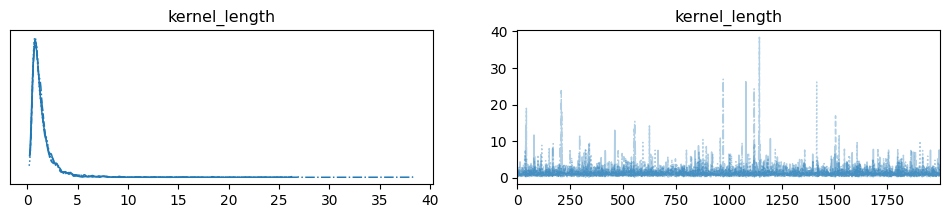

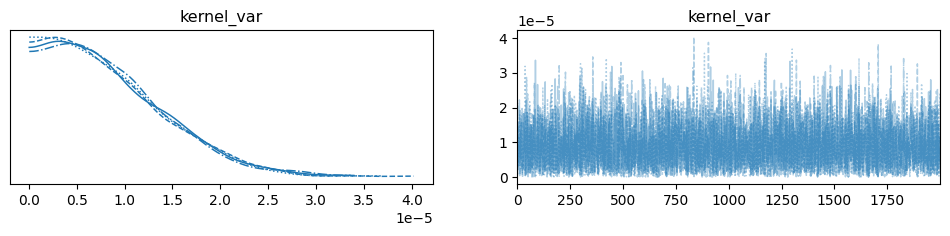

In [ ]:
case_samples_az_gp = az.from_numpyro(mcmc)
az.plot_trace(case_samples_az_gp, var_names = ("kernel_length"))
az.plot_trace(case_samples_az_gp, var_names = ("kernel_var"))

### Calculate and append observed and gp-estimated theta

In [ ]:
samples["theta"].shape

(8000, 20)

In [ ]:
theta_mean_gp = samples["theta"].mean(axis = 0)
bci_gp_25 = np.quantile(samples["theta"],0.25,axis = 0)
bci_gp_75 = np.quantile(samples["theta"],0.75, axis = 0)

df_lo["obs_prev"] = df_lo["Cases"] / df_lo["Population"]
df_hi["obs_prev"] = df_hi["Cases"] / df_hi["Population

df_lo["theta_gp"] = theta_mean_gp[0:n_lo]
df_hi["theta_gp"] = theta_mean_gp[n_lo:n_lo + n_hi]

theta_obs_lo = df_lo["obs_prev"]
theta_gp_est_lo = df_lo["theta_gp"]
theta_obs_hi = df_hi["obs_prev"]
theta_gp_est_hi = df_hi["theta_gp"]

max_val_lo = np.max([theta_obs_lo, theta_gp_est_lo])
min_val_lo = np.min([theta_obs_lo, theta_gp_est_lo])

max_val_hi = np.max([theta_obs_hi, theta_gp_est_hi])
min_val_hi = np.min([theta_obs_hi, theta_gp_est_hi])

# Plot the map

##  (low-res)

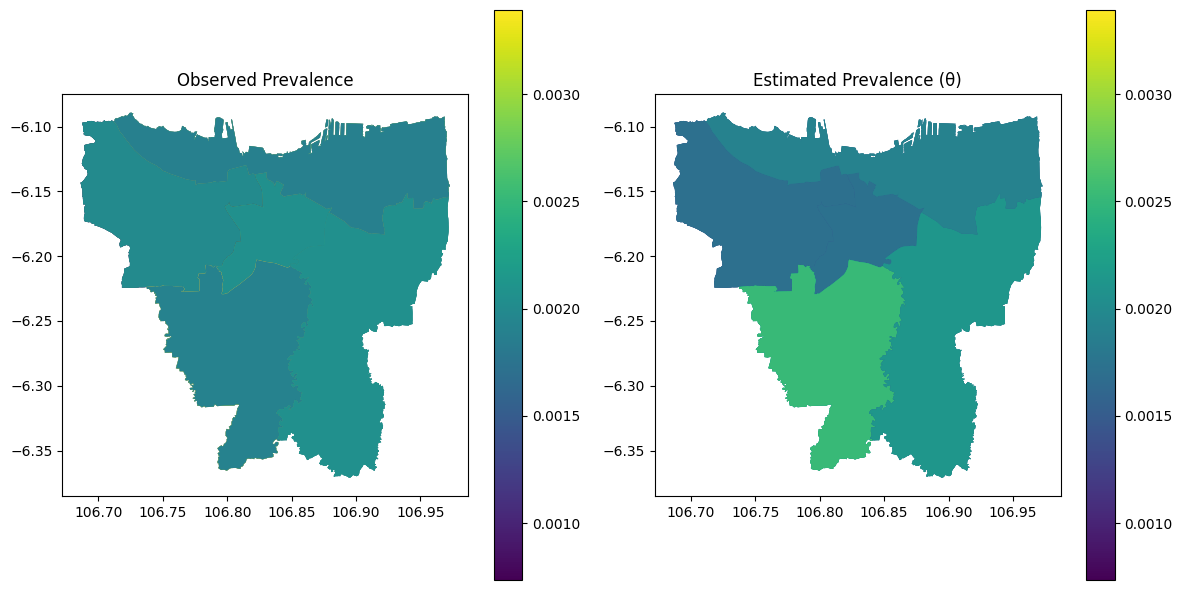

<Figure size 800x600 with 0 Axes>

In [ ]:
# Create the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot observed prevalence on the map
df_lo.plot(
    column="obs_prev",  # Column to use for color
    cmap="viridis",  # Colormap
    vmin=min_val_lo,  # Minimum value for color scale
    vmax=max_val_lo,  # Maximum value for color scale
    legend=True,  # Show legend
    ax=ax[0],  # Plot on the first subplot
)
ax[0].set_title("Low-Res Observed Prevalence")

# Plot estimated prevalence on the map
df_lo.plot(
    column="theta_gp",  # Column to use for color
    cmap="viridis",  # Colormap
    vmin=min_val_lo,  # Minimum value for color scale
    vmax=max_val_lo,  # Maximum value for color scale
    legend=True,  # Show legend
    ax=ax[1],  # Plot on the second subplot
)
ax[1].set_title("Low-Res Estimated Prevalence (θ)")

# Save the plot
plt.savefig("observed_vs_estimated_prevalence_lo.png")  # Save as PNG
# Or save as PDF:
# plt.savefig("observed_vs_estimated_prevalence_lo.pdf")

plt.tight_layout()
plt.show()

#save the plot
plt.figure(figsize=(8, 6))

plt.show()

## high-res

In [ ]:
# Create the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot observed prevalence on the map
df_hi.plot(
    column="obs_prev",  # Column to use for color
    cmap="viridis",  # Colormap
    vmin=min_val_hi,  # Minimum value for color scale
    vmax=max_val_hi,  # Maximum value for color scale
    legend=True,  # Show legend
    ax=ax[0],  # Plot on the first subplot
)
ax[0].set_title("High-Res Observed Prevalence")

# Plot estimated prevalence on the map
df_hi.plot(
    column="theta_gp",  # Column to use for color
    cmap="viridis",  # Colormap
    vmin=min_val_hi,  # Minimum value for color scale
    vmax=max_val_hi,  # Maximum value for color scale
    legend=True,  # Show legend
    ax=ax[1],  # Plot on the second subplot
)
ax[1].set_title("High-Res Estimated Prevalence (θ)")

# Save the plot
plt.savefig("observed_vs_estimated_prevalence_hi.png")  # Save as PNG
# Or save as PDF:
# plt.savefig("observed_vs_estimated_prevalence.pdf")

plt.tight_layout()
plt.show()

#save the plot
plt.figure(figsize=(8, 6))

plt.show()

###Plot scatterplot

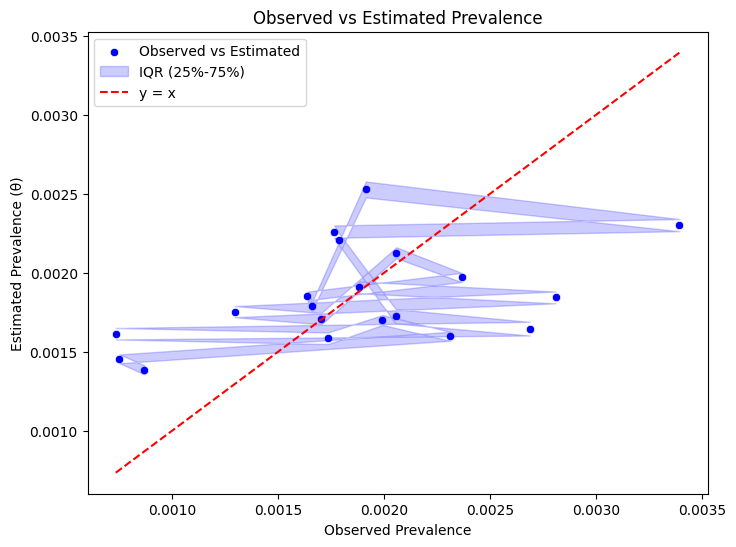

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Convert JAX arrays to NumPy arrays before plotting
def plot_scatter(ax, df, bci_25, bci_75, title, color):
    theta_obs = np.asarray(df["obs_prev"])
    theta_gp_est = np.asarray(df["theta_gp"])
    bci_25 = np.asarray(bci_25)
    bci_75 = np.asarray(bci_75)

    # Compute min and max for plot limits
    _max = max(theta_obs.max(), theta_gp_est.max())
    _min = min(theta_obs.min(), theta_gp_est.min())

    # Scatter plot of observed vs estimated prevalence
    sns.scatterplot(x=theta_obs, y=theta_gp_est, label="Observed vs Estimated", color=color, ax=ax)

    # Add IQR shaded region
    ax.fill_between(theta_obs, bci_25, bci_75, color=color, alpha=0.2, label="IQR (25%-75%)")

    # Plot reference line (y = x) for comparison
    sns.lineplot(x=[_min, _max], y=[_min, _max], color="red", linestyle="--", label="y = x", ax=ax)

    ax.set_xlabel("Observed Prevalence")
    ax.set_ylabel("Estimated Prevalence (θ)")
    ax.set_title(title)
    ax.legend()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for low-res data
plot_scatter(axes[0], df_lo, bci_gp_25, bci_gp_75, "Low-Res Observed vs Estimated Prevalence", "blue")

# Plot for high-res data
plot_scatter(axes[1], df_hi, bci_hi_25, bci_hi_75, "High-Res Observed vs Estimated Prevalence", "green")

# Adjust layout and save figure
plt.tight_layout()
plt.savefig("observed_vs_estimated_prevalence_scatter_side_by_side.png")
plt.show()

In [ ]:
#save df
df_lo.to_csv("df_with_gp_preds_lowres.csv")
df_lo.to_file("df_with_gp_preds_lowres.shp")
df_hi.to_file("df_with_gp_preds_highres.shp")
df_hi.to_csv("df_with_gp_preds_highres.csv")